In [1]:
!pip install transformers

In [2]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.3

Found existing installation: matplotlib 3.7.3
Uninstalling matplotlib-3.7.3:
  Successfully uninstalled matplotlib-3.7.3
  Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires seaborn<0.13,>=0.10.1, but you have seaborn 0.13.0 which is incompatible.


In [3]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

2024-01-12 14:18:34.341570: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Define the connection between Input data and Label

In [5]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [6]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [7]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = "/mnt/train_data.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/train_data.tfrecord


2024-01-12 14:18:42.750379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 14:18:42.772237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 14:18:42.772449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [8]:
print(train_dataset)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [9]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = "/mnt/validation_data.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/validation_data.tfrecord


In [10]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [11]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [12]:
# Adding the layer for fine tuning on BERT

In [13]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [14]:
# Set up the custom classifier model

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

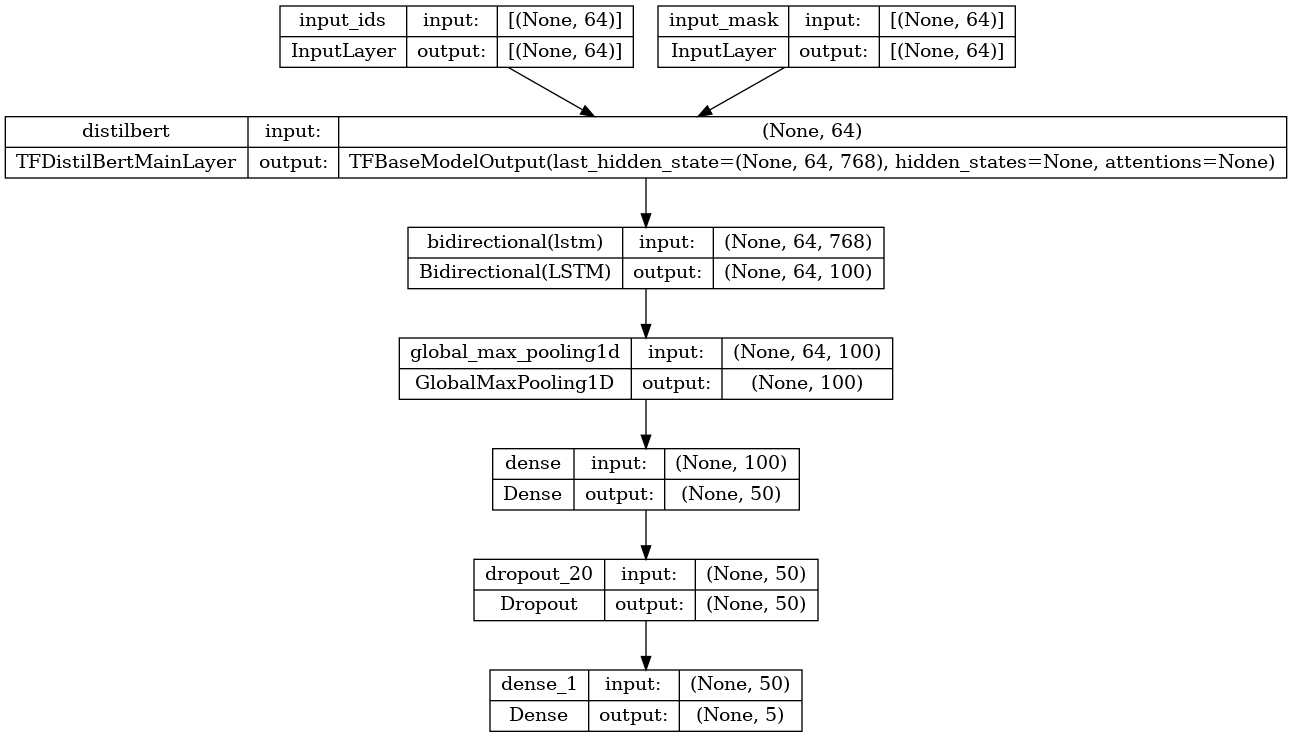

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [17]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [18]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

2024-01-12 14:19:05.074724: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-12 14:19:05.075248: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-12 14:19:15.593

1/1 [==============================] - ETA: 0s - loss: 1.6149 - accuracy: 0.1250

2024-01-12 14:19:17.227412: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-12 14:19:17.227723: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 14s 14s/step - loss: 1.6149 - accuracy: 0.1250 - val_loss: 1.6667 - val_accuracy: 0.2500


In [19]:
epochs = 128
steps_per_epoch = 512
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [20]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/128
512/512 [==============================] - 204s 397ms/step - loss: 1.6061 - accuracy: 0.2207 - val_loss: 1.5838 - val_accuracy: 0.2500
Epoch 2/128
512/512 [==============================] - 206s 402ms/step - loss: 1.5509 - accuracy: 0.3098 - val_loss: 1.5263 - val_accuracy: 0.3125
Epoch 3/128
512/512 [==============================] - 204s 397ms/step - loss: 1.4776 - accuracy: 0.3550 - val_loss: 1.4402 - val_accuracy: 0.3867
Epoch 4/128
512/512 [==============================] - 203s 396ms/step - loss: 1.4050 - accuracy: 0.3879 - val_loss: 1.3630 - val_accuracy: 0.4297
Epoch 5/128
512/512 [==============================] - 203s 397ms/step - loss: 1.3513 - accuracy: 0.3909 - val_loss: 1.3236 - val_accuracy: 0.4766
Epoch 6/128
512/512 [==============================] - 205s 401ms/step - loss: 1.3182 - accuracy: 0.4065 - val_loss: 1.2949 - val_accuracy: 0.4883
Epoch 7/128
512/512 [==============================] - 203s 396ms/step - loss: 1.3010 - accuracy: 0.4290 - val_loss: 1

512/512 [==============================] - 199s 389ms/step - loss: 1.1679 - accuracy: 0.4885 - val_loss: 1.1625 - val_accuracy: 0.5312
Epoch 57/128
512/512 [==============================] - 200s 391ms/step - loss: 1.1661 - accuracy: 0.5000 - val_loss: 1.1566 - val_accuracy: 0.5430
Epoch 58/128
512/512 [==============================] - 199s 389ms/step - loss: 1.1539 - accuracy: 0.4900 - val_loss: 1.1570 - val_accuracy: 0.5273
Epoch 59/128
512/512 [==============================] - 200s 391ms/step - loss: 1.1829 - accuracy: 0.4893 - val_loss: 1.1545 - val_accuracy: 0.5586
Epoch 60/128
512/512 [==============================] - 201s 392ms/step - loss: 1.1541 - accuracy: 0.4907 - val_loss: 1.1731 - val_accuracy: 0.5117
Epoch 61/128
512/512 [==============================] - 199s 390ms/step - loss: 1.1579 - accuracy: 0.5000 - val_loss: 1.1562 - val_accuracy: 0.5234
Epoch 62/128
512/512 [==============================] - 199s 389ms/step - loss: 1.1700 - accuracy: 0.4939 - val_loss: 1.1524 

512/512 [==============================] - 200s 391ms/step - loss: 1.1453 - accuracy: 0.5037 - val_loss: 1.1380 - val_accuracy: 0.5391
Epoch 112/128
512/512 [==============================] - 198s 387ms/step - loss: 1.1429 - accuracy: 0.4978 - val_loss: 1.1220 - val_accuracy: 0.5430
Epoch 113/128
512/512 [==============================] - 203s 396ms/step - loss: 1.1209 - accuracy: 0.5093 - val_loss: 1.1368 - val_accuracy: 0.5312
Epoch 114/128
512/512 [==============================] - 199s 388ms/step - loss: 1.1169 - accuracy: 0.5115 - val_loss: 1.1279 - val_accuracy: 0.5312
Epoch 115/128
512/512 [==============================] - 204s 398ms/step - loss: 1.1097 - accuracy: 0.5190 - val_loss: 1.1360 - val_accuracy: 0.5273
Epoch 116/128
512/512 [==============================] - 201s 393ms/step - loss: 1.1108 - accuracy: 0.5149 - val_loss: 1.1234 - val_accuracy: 0.5234
Epoch 117/128
512/512 [==============================] - 201s 393ms/step - loss: 1.1329 - accuracy: 0.5027 - val_loss: 1

In [21]:
print(history.history)

{'loss': [1.6060901880264282, 1.5509058237075806, 1.4775711297988892, 1.4049543142318726, 1.351270079612732, 1.3181853294372559, 1.3010411262512207, 1.3042644262313843, 1.2521584033966064, 1.2720465660095215, 1.2637124061584473, 1.259907603263855, 1.2402974367141724, 1.2386738061904907, 1.2445652484893799, 1.2318618297576904, 1.2483328580856323, 1.2439545392990112, 1.2453891038894653, 1.2285157442092896, 1.214624285697937, 1.2369358539581299, 1.2132048606872559, 1.2167431116104126, 1.220954179763794, 1.203086018562317, 1.2231138944625854, 1.2110486030578613, 1.2008039951324463, 1.1995896100997925, 1.197178840637207, 1.213154673576355, 1.1816215515136719, 1.2014411687850952, 1.196406364440918, 1.194848895072937, 1.1980470418930054, 1.175865650177002, 1.1917052268981934, 1.1981459856033325, 1.184690237045288, 1.178816795349121, 1.178762674331665, 1.1946529150009155, 1.166279673576355, 1.200448751449585, 1.1710524559020996, 1.17365300655365, 1.1939616203308105, 1.1815663576126099, 1.18012

In [22]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [23]:
# Adhoc predict

In [24]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.8414404988288879}

In [25]:
predict("This is cool.")

1/1 [==============================] - 0s 60ms/step


{'label': 4, 'socre': 0.40611129999160767}

In [26]:
predict("I don't like this.")

1/1 [==============================] - 0s 56ms/step


{'label': 1, 'socre': 0.5264752507209778}

In [27]:
predict("I might buy it again.")

1/1 [==============================] - 0s 55ms/step


{'label': 2, 'socre': 0.30577757954597473}

In [28]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 73ms/step


{'label': 3, 'socre': 0.5844924449920654}

In [29]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

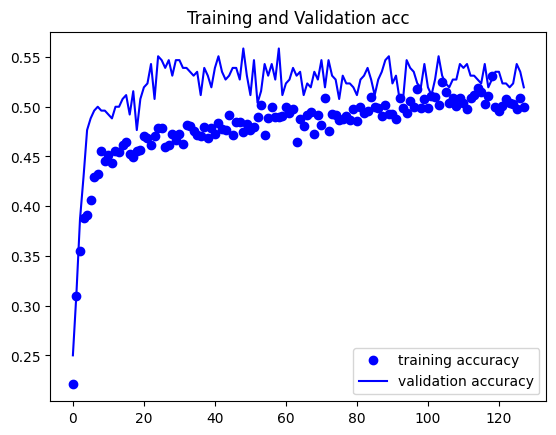

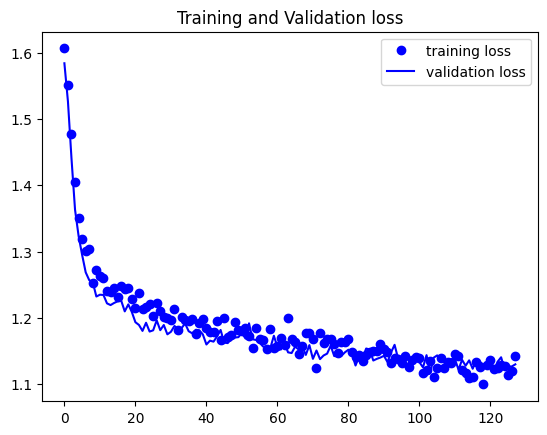

In [30]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [31]:
df = pd.read_parquet("/mnt/amazon_reviews_2015.snappy.parquet",columns=["star_rating","review_id","review_body"])

In [32]:
for i in range(1,6):
    new_df = 'df' + str(i)
    globals()[new_df] = df[df['star_rating'] == i].sample(n=200)

In [33]:
test_df = pd.concat([df1,df2,df3,df4,df5])

In [34]:
test_df.count()

star_rating    1000
review_id      1000
review_body    1000
dtype: int64

In [35]:
test_df['review_id'] = test_df['review_id'].str.decode("utf-8")

In [36]:
test_df['review_body'] = test_df['review_body'].str.decode("utf-8","ignore")

In [37]:
test_df

,star_rating,review_id,review_body
18445504,1,R21R0Z36GP7VKU,Stupid!
32145673,1,R1WOIOXD92RH9C,This product was very much a load of crap! It ...
19774416,1,R19MOX3W4XY350,Terrible!
24850317,1,R3OHFFORHAJREW,Boring. Slow. No storyline. Characters with no...
14263056,1,RRQO4BPPFOMKR,The pans look gorgeous. However the very first...
...,...,...,...
14497830,5,R3H0DUILPGNKZU,nice and bright
14102113,5,R3F7RX428I59YV,Excellent product! I really enjoy this!
4558386,5,R2HN0YW0UHFTEP,Works fine for me. The 2&#34; cubes last a lo...
11524402,5,R5IQPDV6U69V8,My husband is allergic to synthetic materials ...


In [38]:
y_test = test_df['review_body'].map(predict)
y_true = test_df['star_rating']

1/1 [==============================] - 0s 82ms/step


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


In [39]:
print(type(y_test))
y_test2 = [x.get('label') for x in y_test.values]

<class 'pandas.core.series.Series'>


In [40]:
print(type(y_test2))
print(y_test2)

<class 'list'>
[1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 2, 1, 1, 1, 5, 1, 1, 1, 1, 2, 1, 1, 5, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 5, 1, 3, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 5, 1, 1, 2, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 5, 1, 1, 4, 1, 1, 1, 2, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 5, 2, 1, 1, 4, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 3, 4, 2, 3, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 4, 3, 1, 1, 2, 2, 1, 3, 3, 2, 2, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 4, 3, 1, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 1, 2, 1, 1, 2, 3, 2, 4, 4, 1, 1, 2, 2, 2, 5, 3, 1, 2, 1, 2, 2, 2, 2, 2, 4, 1, 2, 3, 3, 2, 2, 3, 1, 2, 3, 3, 

In [41]:
print(type(y_true))
y_true2 = [x for x in y_true.values]

<class 'pandas.core.series.Series'>


In [42]:
print(type(y_true2))
print(y_true2)

<class 'list'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [79]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#print(CLASSES)
cm = confusion_matrix(y_test2, y_true2, labels=CLASSES)
cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
cm_df

,1,2,3,4,5
1,135,52,18,7,7
2,42,96,35,10,5
3,14,37,85,28,9
4,3,8,42,83,29
5,6,7,20,72,150


In [91]:
arrayX = []
for array in cm:
    temp = []
    # print(array)
    for i in range(len(array)):
        # print(array[i])
        sumvalue = array.sum()
        # print(maxvalue)
        # print(array[i])
        # print(array[i]/maxvalue)
        temp.append(array[i]/sumvalue)
    arrayX.append(temp)

# print(arrayX)
arrayX_df = pd.DataFrame(arrayX, index=CLASSES, columns=CLASSES)
arrayX_df

,1,2,3,4,5
1,0.616438,0.237443,0.082192,0.031963,0.031963
2,0.223404,0.510638,0.186170,0.053191,0.026596
3,0.080925,0.213873,0.491329,0.161850,0.052023
4,0.018182,0.048485,0.254545,0.503030,0.175758
5,0.023529,0.027451,0.078431,0.282353,0.588235


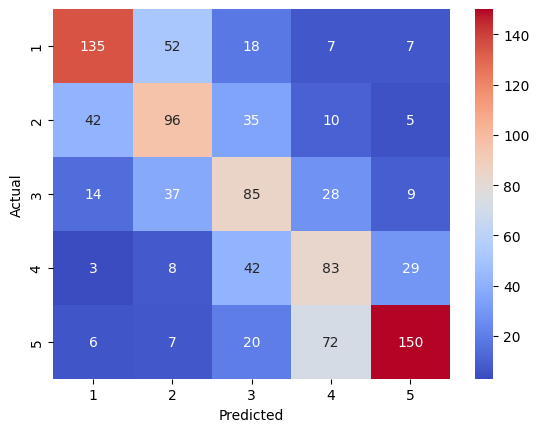

In [44]:
sns.heatmap(cm_df, annot=True, annot_kws={"fontsize":10}, cmap='coolwarm', fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

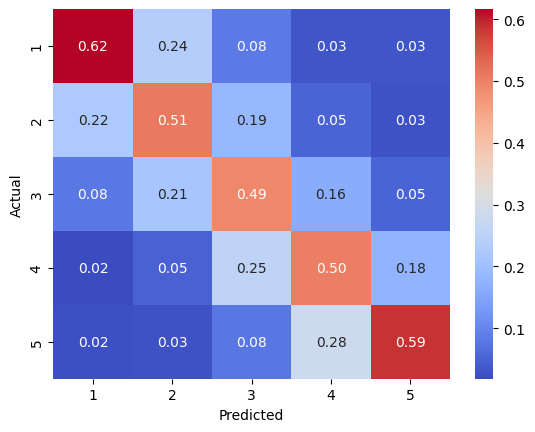

In [95]:
sns.heatmap(arrayX_df, annot=True, annot_kws={"fontsize":10}, cmap='coolwarm', fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
model.save('/mnt/tensorflow/',save_format='tf')

2024-01-12 21:36:18.519062: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-12 21:36:18.611807: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-12 21:36:18.639561: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and sh

2024-01-12 21:36:19.732438: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?]
	 [[{{node inputs}}]]
2024-01-12 21:36:23.074619: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-12 21:36:23.086536: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-12

INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


In [46]:
!ls -l /mnt/tensorflow

total 4912
drwxr-xr-x 2 root root    4096 Jan  9 10:42 assets
-rw-r--r-- 1 root root      55 Jan 12 21:36 fingerprint.pb
-rw-r--r-- 1 root root   98619 Jan 12 21:36 keras_metadata.pb
-rw-r--r-- 1 root root 4914311 Jan 12 21:36 saved_model.pb
drwxr-xr-x 2 root root    4096 Jan 12 21:36 variables


In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>